In [1]:
import numpy as np
from itertools import count
from collections import namedtuple
import pandas as pd
import pandas_datareader.data as web
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
from numpy import array
import matplotlib.pyplot as plt
global tr_p
tr_p =3100
global tr_date
tr_date = '2015/3/25'
global tr_finish
tr_finish = False
global hidden
hidden = (torch.autograd.Variable(torch.zeros(1, 1, 16)),
                                         torch.autograd.Variable(torch.zeros(1, 1, 16)))

In [2]:
torch.manual_seed(543)
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
import requests
url = "https://github.com/xiaoa5/stock-technical-analysis/raw/master/000300tech1.csv"
r = requests.get(url)

with open('000300tech1.csv','w') as f:
  f.write(r.text)
df = pd.read_csv('000300tech1.csv', parse_dates=True)

In [3]:
def load_csv_data(df,col):  
    data_pandas = df[col]
    data = data_pandas .to_numpy()
    result = data
    return result
def normalise_windows(window_data):
    
    normalised_window = [((float(p) / float(window_data[-1])) *0.5) for p in window_data]
        
    return array(normalised_window)

In [4]:
class stock_env:
    def __init__(self):
        print ("init")
        self.price1 = load_csv_data(df,'close')
        self.price2 = load_csv_data(df,'open')
        self.dates = df['date']
        self.hist = 100
        self.train_episode = tr_p
        self.test_episode = len(self.price1) - self.hist - 2
        self.train_done = False
        self.test_done = False
        self.budget = 10000
        self.num_stocks = 0
        self.tr = 25/100000

    def reset(self):   
        global steps_done
        steps_done = 0
        self.budget = 10000
        self.num_stocks = 0
        self.train_done = False
        self.test_done = False
        
        state =normalise_windows( self.price1[steps_done:steps_done+self.hist])
        return state

    def step(self, action): 
        global steps_done
        steps_done += 1
##        if steps_done > self.train_episode:
##            self.train_done = True
        if steps_done > self.test_episode:
            self.test_done = True    

        pre_price = float(self.price2[steps_done + self.hist-1+1])
        pre_portfolio = self.budget + self.num_stocks * pre_price
        pre_date = self.dates[steps_done + self.hist-1+1]
        if action == 0 and pre_price >0: #buy
                    
            while self.budget >= pre_price*(1+self.tr):           
                self.budget -= pre_price *(1+self.tr)
                self.num_stocks += 1
        elif action == 1 and pre_price >0:       #sell
           
            while self.num_stocks > 0:       
                self.budget += pre_price*(1-self.tr)
                self.num_stocks -= 1
        else:
            pass



        try:
            state = normalise_windows(self.price1[steps_done:steps_done+self.hist])
            price = float(self.price2[steps_done + self.hist+1])
            portfolio = self.budget + self.num_stocks * price
            date = self.dates[steps_done + self.hist+1]
            if date == tr_date:
                self.train_done = True
                reward = np.log2(portfolio /self.budget)*2000
##                reward = (portfolio /self.budget - 3.2)*1000
            else:
                reward = 0
                

            reward = (200*(portfolio / pre_portfolio)) - (100*((price / pre_price)+1))
        except:
            reward = 0
        return (state,reward,self.train_done,self.test_done,pre_price,pre_portfolio,pre_date)


In [5]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.rnnLayer = 1
        self.rnnIn = 16
        self.rnnOut = 16
        self.lstm = torch.nn.LSTM(self.rnnIn, self.rnnOut,self.rnnLayer)
        self.cnn1 = torch.nn.Conv1d(1,16,9,stride=2, padding=0, dilation=1, groups=1, bias=True)
        self.affine1 = nn.Linear(46*16, 128)
        self.midd1 = nn.Linear(128, 128)
##        self.midd2 = nn.Linear(128, 128)
##        self.midd3 = nn.Linear(128, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []
        

    def forward(self, x,hiddens):
        x = x.view(1,1,100)
        x = self.cnn1(x)
        x = x.view(46,1,16)
        x, hiddens = self.lstm(x,hiddens)
        x = x.view(-1)
        x = F.tanh(self.affine1(x))
        x = F.tanh(self.midd1(x))
##        x = F.tanh(self.midd2(x))
##        x = F.relu(self.midd3(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values, hiddens


In [6]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-3)  #lr=3e-3
env = stock_env()

init


In [8]:
def select_action(state,hidden):
    state = torch.from_numpy(state).float()
    probs, state_value,hidden = model(Variable(state),hidden)
##    print('action',probs)
    m = Categorical(probs)
    action = m.sample()
##    print('Categorical',action)

    if tr_finish == False:
    
        model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
##    print(action.data[0])
    return action.data


def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []

    for r in model.rewards[::-1]:
##        print('r',r)
##        print('r-----------------------',r)
        R = r + 0.999 * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
  
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = r - value.data

        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]))))
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [11]:
def main():
    model_save_name = "stock_ac2.pkl"
    save_path= F"/content/drive/My Drive/Colab Notebooks/files/{model_save_name}" 
    running_rewards = []
    results = []
    profits = []
    train_results = []
    periods = []
    benchresults = []
    dates = []
    colors = []
    profit_max = 0
    for i_episode in count(1):
        state = env.reset()
        hidden = (torch.autograd.Variable(torch.zeros(1, 1, 16)),
                                         torch.autograd.Variable(torch.zeros(1, 1, 16)))
##        state = torch.from_numpy(state)
##        state = state.unsqueeze(0)
        for t in range(10000):  # Don't infinite loop while learning
            action = select_action(state,hidden)
            
            next_state, reward, tr_finish, ts_done,price,portfolio,date = env.step(action)
##            next_state = torch.from_numpy(next_state)
##            next_state = next_state.unsqueeze(0)

            if t == 0:
                zero_portfolio = portfolio
                zero_value = price
##            if t == 3101:
##                ref_portfolio = portfolio
##                ref_value = price

            if date == tr_date:
                ref_portfolio = portfolio
                ref_value = price
##                record = True
            
            if tr_finish == False:
                model.rewards.append(reward)
            if ts_done:
                break
            state = next_state
        #----------------------------------

        periods.append(i_episode)
        
        results.append(portfolio)
        train_results.append(ref_portfolio/zero_portfolio)
        profit = portfolio/ref_portfolio
        profits.append(profit)
        benchmark = price/ref_value
        print('episode {:4d}'.format(i_episode),
                  'portfolio {:9.2f}'.format(ref_portfolio),   
                  'benchmark {:5.3f}'.format(benchmark),
                  'profit {:5.3f}'.format(profit))
        
        

        
        try:
            temp = running_reward
        except:
            running_reward = portfolio
            
        running_reward = running_reward * 0.95 + portfolio * 0.05
        running_rewards.append(running_reward)
        
        finish_episode()
        if profit > profit_max and ref_portfolio > 30000 :
            
            profit_max = profit
            torch.save(model, save_path)
            print('model saved.')
        if i_episode % 10 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
        if running_reward > 30000: #env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break



    
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Train episodes')
    ax1.set_ylabel('Train Profit (bis 25 März 2015)', color=color)
    ax1.plot(periods,train_results, color=color)
    ax1.tick_params(axis='y', labelcolor=color)    

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Validation Profit (seit 26 März 2015)', color=color)  # we already handled the x-label with ax1
    ax2.plot(periods,profits, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode    1 portfolio  10203.42 benchmark 1.014 profit 0.915
episode    2 portfolio  11989.42 benchmark 1.014 profit 0.842
episode    3 portfolio  20537.77 benchmark 1.014 profit 0.898
episode    4 portfolio   6979.19 benchmark 1.014 profit 1.149
episode    5 portfolio  22711.03 benchmark 1.014 profit 1.358
episode    6 portfolio   5385.40 benchmark 1.014 profit 0.804
episode    7 portfolio   9677.90 benchmark 1.014 profit 0.834
episode    8 portfolio   6522.10 benchmark 1.014 profit 1.064
episode    9 portfolio   9080.50 benchmark 1.014 profit 1.023
episode   10 portfolio   8402.23 benchmark 1.014 profit 1.383
Episode 10	Last length:  3768	Average length: 10209.18
episode   11 portfolio   8570.32 benchmark 1.014 profit 0.788
episode   12 portfolio   4084.16 benchmark 1.014 profit 1.260
episode   13 portfolio  37847.49 benchmark 1.014 profit 1.520
model saved.
episode   14 portfolio   7815.65 benchmark 1.014 profit 0.773
episode   15 portfolio   8440.79 benchmark 1.014 profit 1.052
ep

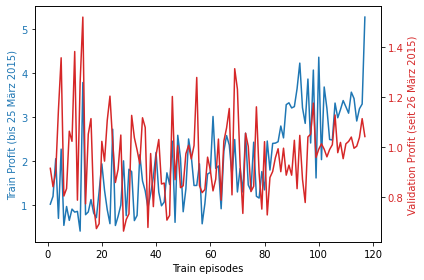

In [12]:
main()